# <center> </center>
# <center> 9d. GARCH Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['rugarch']
RPY.load_R_packages(R_packages)

R packages loaded: rugarch


Load Python packages

In [4]:
pth_packages = ['yfinance']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf, matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# 1. Data
Data: S&P500 index ([Source](https://finance.yahoo.com/quote/^GSPC/)), for plots see file "9a. Volatility"

In [5]:
GSPC = yf.download('^GSPC', start='2000-01-01', end='2025-03-01', progress=False, auto_adjust=False)
SP500 = GSPC['Close']
SP500_r = np.log(SP500/SP500.shift(1)).dropna()*100  # in % terms

Split data into 90% training and 10% validation

In [6]:
train_size = int(0.9 * len(SP500_r))
train_data = SP500_r[:train_size]
val_data = SP500_r[train_size:]

In [7]:
ro.globalenv['train_data'] = train_data
ro.globalenv['val_data'] = val_data
ro.globalenv['SP500_r'] = SP500_r

# 2. ARCH Model
ARCH model specification (sGARCH is the "standard" GARCH model). The format of `garchOrder=` is c(number of ARCH parameters, number of GARCH parameters).

In [8]:
%%R
arch_spec <- rugarch::ugarchspec(
             variance.model = list(model="sGARCH", garchOrder=c(10, 0)), 
             mean.model = list(armaOrder=c(0, 0)))

ARCH model estimation on the training data

In [9]:
%%R
arch_fit <- rugarch::ugarchfit(spec=arch_spec, data=train_data, solver="hybrid")

Forecast volatility (variance) on the validation data and output MSE

In [10]:
%%R
h_steps <- nrow(val_data)
arch_forecast <- rugarch::ugarchforecast(fit=arch_fit, n.ahead=h_steps)
std_dev_a <- as.numeric(arch_forecast@forecast$sigmaFor) # standard deviations

In [11]:
std_dev_a = ro.globalenv['std_dev_a'] 
var_a = std_dev_a**2 # variances
mse_val_a = np.mean((np.array(val_data) - var_a.reshape(-1, 1))**2)
print(f"MSE: {round(mse_val_a, 1)}")

MSE: 3.2


# 3. GARCH Model
GARCH model specification

In [12]:
%%R
garch_spec <- rugarch::ugarchspec(
              variance.model = list(model="sGARCH", garchOrder=c(1,1)), 
              mean.model = list(armaOrder=c(0,0)))

GARCH model estimation on the training data

In [13]:
%%R
garch_fit <- rugarch::ugarchfit(spec=garch_spec, data=train_data, solver="hybrid")

Forecast volatility (variance) on the validation set and output MSE

In [14]:
%%R
garch_forecast <- rugarch::ugarchforecast(fit=garch_fit, n.ahead=h_steps)
std_dev_g <- as.numeric(garch_forecast@forecast$sigmaFor) # standard deviations

In [15]:
std_dev_g = ro.globalenv['std_dev_g'] 
var_g = std_dev_g**2 # variances
mse_val_g = np.mean((np.array(val_data) - var_g.reshape(-1, 1))**2)
print(f"MSE: {round(mse_val_g, 1)}")

MSE: 2.7


Note that GARCH(1,1) with fewer parameters has lower validation MSE and hence more accurate forecast than ARCH(10).

<div style="page-break-after: always;"></div>

# 4. GARCH Forecast

Fitted in-sample volatility (variance)

In [16]:
%%R
garch_fit <- rugarch::ugarchfit(spec=garch_spec, data=SP500_r, solver="hybrid")
std_dev <- garch_fit@fit$sigma # standard deviations
var <- std_dev^2 # variances

In [17]:
var = pd.DataFrame(ro.globalenv['var'])
var.index = SP500_r.index

Out-of-sample forecast of volatility (variance)

In [18]:
%%R
h_steps <- 20
garch_forecast <- rugarch::ugarchforecast(fit=garch_fit, n.ahead=h_steps)
std_dev_fc <- garch_forecast@forecast$sigmaFor # standard deviations
var_fc <- std_dev_fc^2 # variances

In [19]:
var_f = pd.DataFrame(ro.globalenv['var_fc'])
h_steps = int(ro.globalenv['h_steps'][0])
id = SP500_r.index  
id_f = pd.date_range(start=id[-1] + pd.offsets.BDay(1), periods=h_steps, freq="B")
var_f.index = id_f

Plot

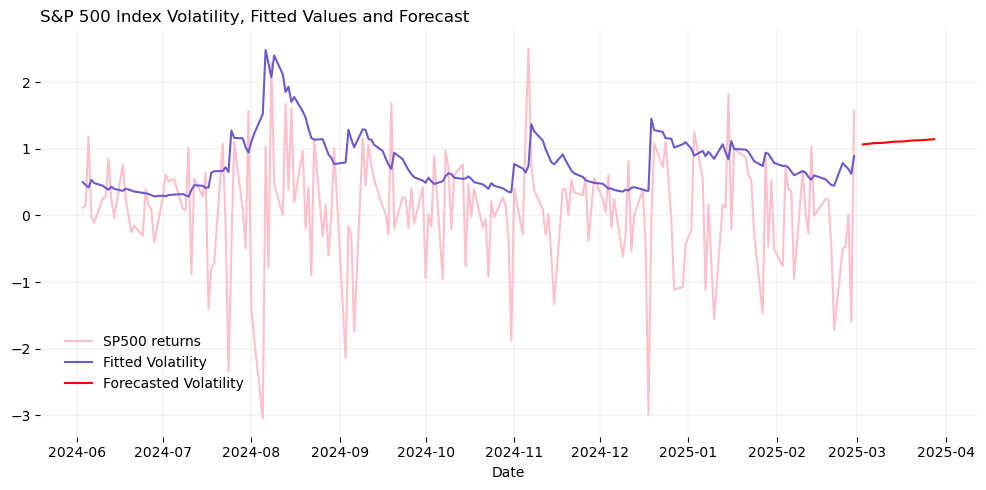

In [20]:
start_plot = pd.to_datetime('2024-06-01')
var_s = var[var.index >= start_plot]
SP500_rs = SP500_r[SP500_r.index >= start_plot]

plt.figure(figsize=(10, 5))
plt.plot(SP500_rs.index, SP500_rs, label='SP500 returns', color='pink', linestyle='-')
plt.plot(var_s.index, var_s, label='Fitted Volatility', color='slateblue', linestyle='-')
plt.plot(var_f.index, var_f, label='Forecasted Volatility', color='red', linestyle='-')

plt.xlabel('Date')
plt.ylabel('')
plt.title('S&P 500 Index Volatility, Fitted Values and Forecast', loc='left')
plt.legend(loc=(0.02, 0.1), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.grid(which='minor', color='lightgrey', linewidth=0.2)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()